In [1]:
from scipy.integrate import solve_ivp
import numpy as np
import matplotlib.pyplot as plt

## Equations
$$\frac{dY}{dt} = Y \bigg[w_O c_O O + [w_S^{ana}​+(w_S^{aer}​−w_S^{ana}​)f(O)]c_S S - m\bigg]$$

$$\frac{dO}{dt} = -c_O O Y f(O)$$

$$\frac{dS}{dt} = r_S S (1 - \frac{S}{P_S}) - c_S Y S$$

## Units and notes

**Populations**   
Everything is in concentrations.  
- $Y$ (yeast): $\frac{g_Y}{L}$ (dry yeast per liter of dough).  
- $O$ (oxygen): $\frac{mmol}{L}$ (millimoles of $O_2$ per liter of dough).  
- $S$ (sugar): $\frac{GGE}{L}$ (grams of glucose-equivalent per liter of dough).  

**Growth Parameters**
- $K_O$: $\frac{mmol}{L}$ Half saturation for Oxygen. Below this we get pretty anaerobic. Appears in $f(O)$ formula, matches $O$ units in denominator. 
- $K_S$: $\frac{GGE}{L}$ Half saturation for Sugar.
- $P_S$: $\frac{g_S}{L}$ Carrying capacity for sugar, or saturation or whatever.  
- $r_S$: $\frac{1}{h}$ Sugar logistic growth rate, how fast it appears.  
- $f(O)$: $\frac{mmol}{L}$ Monod equation with oxygen, oxygen availibility switch. Near 1 when oxygen is plentiful, near 0 when it's gone. Controls how efficient sugar metabolism is with $[w_S^{ana}​+(w_S^{aer}​−w_S^{ana}​)f(O)]$.  

**Yield**   
resource consumed $\rightarrow$ biomass added. 
- $w_S^{aer}$: $\frac{g_Y}{g_S}$ aerobic ATP yield, very efficient.  
- $w_S^{ana}$: $\frac{g_Y}{g_S}$ anaerobic ATP yield, inefficient.  
- $w_O$: $\frac{g_Y}{mmol}$ Oxygen yield.  
These are multiplied by the $c_SSY$ and $c_OOY$ terms--for how much resource disappears, how much consumer appears?

**Uptake**
- $c_S$: $\frac{L}{g_Yh}$ This is sugar uptake, how quickly yeast processes sugar per unit biomass. So $c_SSY$ is in GGE / Lh, or concentration of sugar per hour.  
- $c_O$: $\frac{L}{g_Yh}$ Oxygen uptake, how quickly yeast processes Oxygen per unit biomass. So $c_OOY$ is $\frac{mmol}{Lh}$.  

In [ ]:
wo, co, waer, wana, ko, cs, m, rs, ks = .2, 1, .35, .05, .2, .08, .05, .15, 10
# wo, co, waer, wana, ko, cs, m, rs, ks = .2, 1, .35, .1, .2, .08, .05, .1, 20
# wo, co, waer, wana, ko, cs, m, rs, ks = .02, 1, .035, .008, .1, .08, .05, .05, 20
# wo, co, waer, wana, ko, cs, m, rs, ks = .02, .5, .035, .008, .1, .08, .05, .1, 20
# wo, co, waer, wana, ko, cs, m, rs, ks = .02, .4, .035, .008, .1, .08, .005, .08, 20

def ode(t, yos):
    Y, O, S = yos
    fO = O / (ko + O)

    dY = Y * (wo * co * O * fO + (waer + (waer - wana) * fO) * cs * S - m)
    dO = -co * Y * fO
    # dS = S * (ks - Y * cs - S)
    dS = rs * S * (1 - (S / ks)) - cs * Y * S

    return np.array([dY, dO, dS])

t0, tf = 0, 240
t_span = (t0, tf)
t_eval = np.linspace(t0, tf, 360)

# y0 = np.array([1, .25, 1])
y0 = np.array([1, .25, .5])

sol = solve_ivp(ode, (t0, tf), y0, t_eval=t_eval)

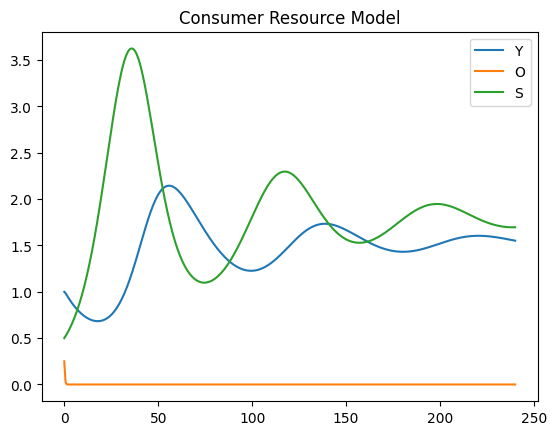

In [3]:
plt.plot(t_eval, sol.y[0, :], label='Y')
plt.plot(t_eval, sol.y[1, :], label='O')
plt.plot(t_eval, sol.y[2, :], label='S')
plt.title("Consumer Resource Model")
plt.legend()

plt.show()

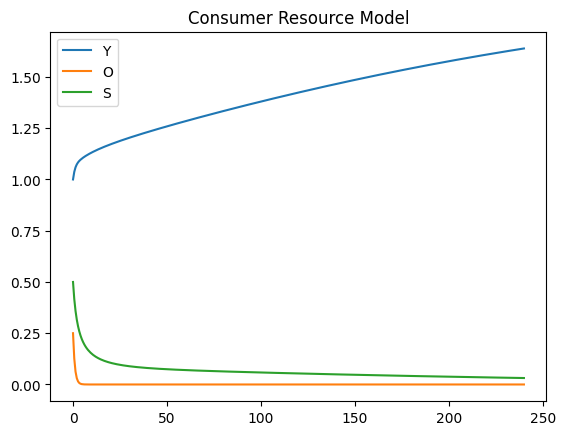

In [8]:
wo, waer, wana = .2, .35, .05

ko, ks = .2, .2

ps, rs = 10, .15

cs, co, m = .08, 1, 0

params = (wo, waer, wana, ko, ks, ps, rs, cs, co, m)



def solve_and_graph(params):
    wo, waer, wana, ko, ks, ps, rs, cs, co, m = params
    def ode(t, yos):
        Y, O, S = yos
        fO = O / (ko + O)
        fS = S / (ks + S)

        dY = Y * (wo * co * O + (waer + (waer - wana) * fO) * cs * S - m)
        dO = -co * Y * O
        # dS = S * (ks - Y * cs - S)
        dS = rs * S * (1 - (S / ks)) - cs * Y * S

        return np.array([dY, dO, dS])

    t0, tf = 0, 240
    t_span = (t0, tf)
    t_eval = np.linspace(t0, tf, 360)

    # y0 = np.array([1, .25, 1])
    y0 = np.array([1, .25, .5])

    sol = solve_ivp(ode, (t0, tf), y0, t_eval=t_eval)

    plt.plot(t_eval, sol.y[0, :], label='Y')
    plt.plot(t_eval, sol.y[1, :], label='O')
    plt.plot(t_eval, sol.y[2, :], label='S')
    plt.title("Consumer Resource Model")
    plt.legend()

    plt.show()

solve_and_graph(params)

The previous models make the following simplifying assumptions:

- All sugar is available up front and only decreases.
- Yeast's consumption of sugar only depends on the amount of yeast and sugar.
- Oxygen is not considered as a resource on which yeast feeds.

Perhaps we can make assumptions that are closer to reality in our model and better approximate the real dynamics in a rising loaf of dough. A more appropriate family of models to use would be Consumer-Resource models, which are designed to factor in multiple consumers and multiple resources. A special case of these models are Lotka-Volterra predator-prey models, which have a single consumer and a single resource. This family of models considers the replenishment of the resource, predators' preference for different resources (called uptake in this paper), and the yield in biomass for the consumer per unit of resource consumed. In the case considered by this paper, there is a single consumer (yeast), and two resources (sugar and oxygen). Additionally, both the uptake and yield of sugar vary with the amount of oxygen, as we will discuss.

The general form of the MacArthur consumer-resource model for S species of consumers with concentrations $N_i$ for $i \in {1, 2, ..., S}$, and M resources with concentrations $R_{\alpha}$ for $\alpha \in {1, 2, ..., M}$ is
$$\frac{dN_i}{dt} = N_i \sum_\alpha (u_{i\alpha}(R_{\alpha}) w_{i\alpha} R_\alpha) - m_i$$
$$\frac{dR_\alpha}{dt} = F_{\alpha} (R_{\alpha}) - \sum_i (N_i u_{i\alpha}(R_{\alpha}))$$

u_{i\alpha} controls the *uptake* of the resource by the consumer, or how quickly consumer $i$ consumes resource $\alpha$ per unit biomass. This can vary with the concentration of the resource, as it can [saturate](https://www.biorxiv.org/content/10.1101/385724v6.full?.com), or we can keep it a simple constant. $w_{i\alpha}$ is the *yield* that resource $\alpha$ provides consumer $i$, and controls the proportion between resource $\alpha$ consumed and biomass added to consumer $i$. $m_i$ is the minimum maintenance amount (**BUT ALSO NATURAL MORTALITY RATE, FIX). $F_{\alpha}$ is the function that controls the replenishment of resource $\alpha$ in the absence of consumers.

There are a lot of parameters and a lot of corresponding units. We will first provide a sort of index of these parameters in order to be clear as to their purpose and their dimensions. In the section below we will discuss where these parameters come into play.

#### Parameters, dimensions, and notes

**Populations**   
Everything is in concentrations.  
- $Y$ (yeast): $\frac{g_Y}{L}$ (dry yeast per liter of dough).  
- $O$ (oxygen): $\frac{mmol}{L}$ (millimoles of $O_2$ per liter of dough).  
- $S$ (sugar): $\frac{GGE}{L}$ (grams of glucose-equivalent per liter of dough).  

**Growth Parameters**
- $K_O$: $\frac{mmol}{L}$ Half saturation for Oxygen. Below this we get pretty anaerobic. Appears in $f(O)$ formula, matches $O$ units in denominator. 
- $K_S$: $\frac{GGE}{L}$ Half saturation for Sugar.
- $P_S$: $\frac{g_S}{L}$ Carrying capacity for sugar, or saturation or whatever.  
- $r_S$: $\frac{1}{h}$ Sugar logistic growth rate, how fast it appears.  
- $f(O)$: $\frac{mmol}{L}$ Monod equation with oxygen, oxygen availibility switch. Near 1 when oxygen is plentiful, near 0 when it's gone. Controls how efficient sugar metabolism is with $[w_S^{ana}​+(w_S^{aer}​−w_S^{ana}​)f(O)]$.  

**Yield**   
resource consumed $\rightarrow$ biomass added. 
- $w_S^{aer}$: $\frac{g_Y}{g_S}$ aerobic ATP yield, very efficient.  
- $w_S^{ana}$: $\frac{g_Y}{g_S}$ anaerobic ATP yield, inefficient.  
- $w_O$: $\frac{g_Y}{mmol}$ Oxygen yield.  
These are multiplied by the $c_SSY$ and $c_OOY$ terms--for how much resource disappears, how much consumer appears?

**Uptake**
- $c_S$: $\frac{L}{g_Yh}$ This is sugar uptake, how quickly yeast processes sugar per unit biomass. So $c_SSY$ is in GGE / Lh, or concentration of sugar per hour.  
- $c_O$: $\frac{L}{g_Yh}$ Oxygen uptake, how quickly yeast processes Oxygen per unit biomass. So $c_OOY$ is $\frac{mmol}{Lh}$.  

Ordinarily, and in our hyptothetical experiment, there is no baking sugar added to the dough. The sugar present is tied up in the flour. When the flour gets wet and is kneaded, enzymes in the flour go to work breaking down the sugar--rather than all the sugar being available at once, it replenishes logistically. Therefore we must add a replenishing term to our change of sugar equation. The change in sugar equation becomes
$$\frac{dS}{dt} = r_S S (1 - \frac{S}{P_S}) - c_S Y S$$
where $\frac{dS}{dt}$ is the change in sugar over time in $\frac{GGE}{L \cdot h}$, $- c_S Y S$ is instantaneous amount of sugar metabolized by yeast, and $r_S S (1 - \frac{S}{P_S})$ is the logistic replenishment term, where $r_S$ is the logistic growth constant and $P_S$ is the total amount of sugar in the loaf, available or unavailable.  
**NOTE:** We should think about this. Is it logistic? Shouldn't the carrying capacity be changing because there is ever less sugar? If the yeast disappeared at some point, the sugar would no longer be approaching the same limit.

Additionally, both the *rate* at which yeast consumes sugar (uptake) and the *yield* sugar provides yeast varies with the amount of oxygen available. When oxygen is plentiful, yeast metabolizes sugar aerobically, which is both quicker and creates more energy for the yeast to grow. When oxygen is low, yeast metabolizes the sugar less anaerobically, which is less efficient. Our model should reflect this--a relatively short burst of growth until oxygen is depleted, and then slow, anaerobic growth from there on out. The anaerobic metabolism creates CO_2 and ethanol as byproducts, and is called fermentation. In our model, we want to include a smooth switch between aerobic and anaerobic metabolism. We accomplish this via a switching function, which we name f in our model.
$$f(O) = \frac{O}{K_O + O}$$
Where $O$ is the amount of oxygen and $K_O$ is the half-saturation constant, where yeast behaves 50% aerobically and 50% anaerobically. The full yield term, which controls the yield that sugar provides the yeast, is like so.
$$w_S^{eff} = [w_S^{ana}​+(w_S^{aer}​−w_S^{ana}​)f(O)]$$
Thus, when $O \gg K_O$, $f(O) \approx 1$, and $w_S^{eff} \approx w_S^{aer}$ indicating fully aerobic yield. Likewise, when $O \ll K_O$, $f(O) \approx 0$, and $w_S^{eff} \approx w_S^ana$, indicating fully anaerobic yield. 

By assembling these pieces into the general MacArthur consumer resource model found above,

$$\frac{dY}{dt} = Y \bigg[w_O c_O O + [w_S^{ana}​+(w_S^{aer}​−w_S^{ana}​)f(O)]c_S S - m\bigg]$$

$$\frac{dO}{dt} = -c_O O Y$$

$$\frac{dS}{dt} = r_S S (1 - \frac{S}{P_S}) - c_S Y S$$